# Evaluation of EchoNet

Comparison of the effect of various Positional Encodings on ViTs performance on echocardiography ejection fraction regression.  

This notebook contains
1. Basic dataset overview
2. Predictions on test data
3. Performance metric overview
4. Significance testing

In [1]:
# Basic i/o
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# Data analysis
import numpy as np
import pandas as pd
import torch

# Metrics
from scipy.stats import ttest_rel
from torchmetrics import MetricCollection
from torchmetrics import (
    MeanAbsoluteError,
    MeanSquaredError,
    R2Score,
)
from torchmetrics.wrappers import BootStrapper
from lightning.pytorch import seed_everything

# Dataset and model
from posenc.datasets.echonet import EchoNetDataModuleV2
from posenc.modules.video_regression import VideoViTModule

# Global settings
sns.set_style("whitegrid")
seed_everything(4242)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_DIR = Path("../checkpoints/echonet")
RESULTS_PATH = Path("../results/echonet_predictions.csv")

MODELS = {p.parent.name: p for p in CHECKPOINT_DIR.rglob("*.ckpt")}
print("Running on:", DEVICE)

Seed set to 4242


Running on: cpu


## Dataset overview

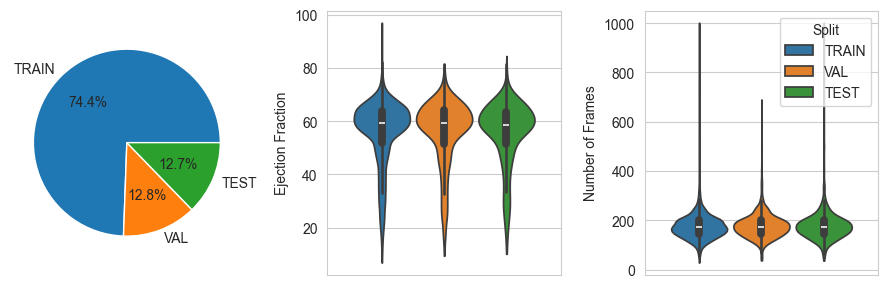

In [2]:
meta = pd.read_csv('../datasets/FileList.csv')

splits = list(meta.Split.value_counts().index)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(9, 3)
axs[0].pie(meta.Split.value_counts().values, labels=splits, autopct='%1.1f%%')
sns.violinplot(data=meta, y="EF", hue="Split", ax=axs[1], legend=False, hue_order=splits, cut=0, gap=0.1)
sns.violinplot(data=meta, y="NumberOfFrames", hue="Split", ax=axs[2], legend=True, hue_order=splits, cut=0, gap=0.1)
axs[1].set_ylabel("Ejection Fraction")
axs[2].set_ylabel("Number of Frames")
plt.tight_layout()
plt.show()

## Predict on test data

In [3]:
@torch.no_grad()
def predict(model, loader):
    """Prediction generator given a dataloader and model."""
    model.eval()
    for batch in tqdm(loader):
        x = batch["image"].to(DEVICE)
        y = batch["target"]
        y_hat = model(x).cpu()
        yield y_hat, y

def generate_results(save_path=None, num_workers=32):
    """Takes a model_name:model_path dictonary and an output path to generate results."""

    data = EchoNetDataModuleV2(batch_size=32, num_workers=12, period=4, length=16)
    data.setup()
    loader = data.test_dataloader()
    
    res = defaultdict(list)
    nsamples = 0
    for model_name, path in MODELS.items():

        model_path = CHECKPOINT_DIR / path
        torch.manual_seed(4242)
        model = VideoViTModule.load_from_checkpoint(model_path, map_location=torch.device(DEVICE))
        
        print("Evaluating", model_name)
        for y_hat, y in predict(model, loader):
            n_labels = len(y_hat)
            n_samples = n_labels // 20
            
            res["pred"] += y_hat.tolist()
            res["model"] += [model_name] * n_labels
            res["y"] += y.tolist()

    df = pd.DataFrame(res)

    if save_path is not None:
        df.to_csv(save_path)

    return df

In [4]:
if RESULTS_PATH.is_file():
    df = pd.read_csv(RESULTS_PATH, index_col=0)
else:
    df = generate_results(save_path=None, num_workers=32)

## Performance metric overivew

In [5]:
metric_collection = MetricCollection({
    "MAE": BootStrapper(MeanAbsoluteError(), num_bootstraps=1000),
    "RMSE": BootStrapper(MeanSquaredError(squared=False), num_bootstraps=2000),
    "R2": BootStrapper(R2Score(), num_bootstraps=2000)
})

In [6]:
results = defaultdict(list)
for model, group in tqdm(df.groupby("model")):
    y_true = torch.tensor(group.y.values, dtype=torch.float)
    y_pred = torch.tensor(group.pred.values, dtype=torch.float)

    metrics = metric_collection(y_pred, y_true)

    for metric in metric_collection.keys():
        results["metric"].append(metric)
        results["mean"].append(metrics[f"{metric}_mean"].item())
        results["std"].append(metrics[f"{metric}_std"].item())
        results["model"].append(model)
results = pd.DataFrame(results)

100%|██████████| 6/6 [00:31<00:00,  5.22s/it]


In [7]:
best_models = results[results.metric == "MAE"].sort_values("mean", ascending=True)
best_models.round(3)

,metric,mean,std,model
0,MAE,5.491,0.137,afpe
3,MAE,5.870,0.161,fpe
9,MAE,5.938,0.164,lfpe
15,MAE,6.177,0.161,spe
6,MAE,7.312,0.188,learnable
12,MAE,7.595,0.206,none


In [8]:
best_models = results[results.metric == "R2"].sort_values("mean", ascending=False)
best_models.round(3)

,metric,mean,std,model
1,R2,0.621,0.024,afpe
4,R2,0.548,0.028,fpe
16,R2,0.527,0.030,spe
10,R2,0.523,0.030,lfpe
7,R2,0.333,0.030,learnable
13,R2,0.284,0.035,none


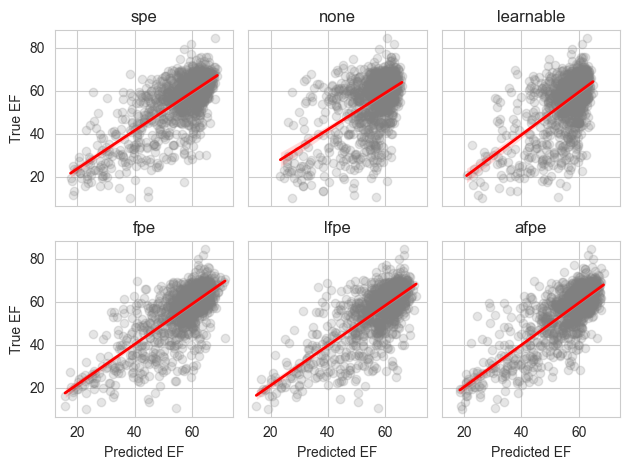

In [9]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), df.model.unique())):
    group = df[df.model == model]

    sns.regplot(group, x="pred", y="y", ax=ax, scatter_kws=dict(alpha=0.2, color="gray"), line_kws=dict(lw=2, color="red"))
    ax.set_title(model)
    
    ylabel = ""
    xlabel = ""
    
    if i == 0 or i == 3:
        ylabel = "True EF"
    if i > 2:
        xlabel = "Predicted EF"
    ax.set_xlabel(xlabel)       
    ax.set_ylabel(ylabel)    
plt.tight_layout()
plt.show()

## Significance testing

In [10]:
top_two_models = best_models.model.iloc[:2].values

In [11]:
R2 = BootStrapper(R2Score(), num_bootstraps=1000, raw=True)

top_two = []
for model, group in df.groupby("model"):

    if model not in top_two_models:
        continue
    y_true = torch.tensor(group.y.values, dtype=torch.float)
    y_pred = torch.tensor(group.pred.values, dtype=torch.float)

    # Compute metrics
    torch.manual_seed(4242)  
    performance = R2(y_pred, y_true)["raw"]
    top_two.append(performance)

# This test is robust to normality violations if num_bootstraps is large (due to the Central Limit Theorem).
pvalue = ttest_rel(*top_two).pvalue
if pvalue < 0.05:
    print(f"\n The top two models are statistically significantly different from each other (p=={pvalue:.3f}).")
else:
    print(f"\n The top two models are not statistically significantly different from each other (p=={pvalue:.3f}).")


 The top two models are statistically significantly different from each other (p==0.000).
